In [35]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from tensorboard.plugins.hparams import api as hp

from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils import class_weight
from tensorflow.keras.layers import LSTM,Embedding,Dense,Dropout,Bidirectional,GlobalMaxPool1D,GlobalAveragePooling1D, SpatialDropout1D

from flair.embeddings import StackedEmbeddings

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
def preprocess(sent, lemmatizer, stop_words):
    
    alphabet = "abcdefghijklmnopqrstuvwxyz 0123456789',."
    sent = sent.lower()
    sent = sent.replace('@user','')
    sent = sent.replace('@[\w\-]+','')

    cleaned_sent_list = [char if char in alphabet else ' ' for char in sent] # remove all tags not in the alphabet

    cleaned_sent = ''.join(cleaned_sent_list)
    cleaned_sent_list = [lemmatizer.lemmatize(token) for token in cleaned_sent.split(" ")]
    cleaned_sent_list = [word for word in cleaned_sent_list if not word in stop_words]
    cleaned_sent = ' '.join(cleaned_sent_list)
    cleaned_sent = cleaned_sent.replace("n't",' not') # replace words like "isn't" with "is not"
    cleaned_sent = ' . '.join([x for x in cleaned_sent.split('.') if len(x)>0]) # remove multiple periods, and add spaces before and after a period
    cleaned_sent = ' , '.join([x for x in cleaned_sent.split(',') if len(x)>0]) # add spaces before and after a comma
    cleaned_sent = ' '.join(cleaned_sent.split()) # remove multiple spaces
    return cleaned_sent

In [37]:
olid_data = pd.read_csv("data/OLIDv1/olid-training-v1.0.tsv", sep='\t')


In [38]:
X_train = olid_data.tweet
y_train = pd.factorize(olid_data.subtask_a)[0]

X_test=pd.read_csv('data/OLIDv1/testset-levela.tsv',sep="\t").tweet
y_test=pd.read_csv( 'data/OLIDv1/labels-levela.csv',header=None).iloc[:,-1]
y_test = pd.factorize(y_test)[0]
import collections
collections.Counter(y_train)
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')


X train shape: (13240,), y train shape: (13240,)


Splitting data into train hold out sets.
Our split will be 80% train, 20% validation 

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.3, random_state=42)
# check shapes of train, test and validation data
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X valid shape: {X_valid.shape}, y valid shape: {y_valid.shape}')
print(f'X valid shape: {X_test.shape}, y test shape: {y_test.shape}')


X train shape: (9268,), y train shape: (9268,)
X valid shape: (3972,), y valid shape: (3972,)
X valid shape: (860,), y test shape: (860,)


Data preprocessing. 

In [40]:

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
data_train = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_train]
data_valid = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_valid]
data_test = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_test]

In [41]:
data_train[0], data_valid[0], data_test[0]

('truly . anything avoid gun control',
 'john kerry running mouth cared ha say think single damn thing kerry ha accomplished besides run mouth . trump accomplishment exceed anything kerry could ever dream of . even becoming president',
 'whoisq wherestheserver dumpnike declasfisa democrat support antifa , muslim brotherhood , ms13 , isis , pedophilia , child trafficking , taxpayer funded abortion s , election fraud , sedition treason lockthemallup wwg1wga qanon url')

Tokenisation and padding for sentences


# Glove Embeddings
References: https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html

In [42]:
glove_path = "embeddings/glove.840B.300d.txt"

In [43]:
fasttext_path = "embeddings/wiki-news-300d-1M.vec"

In [44]:
def get_word_vectors(word, *arr):
    return word, np.array(arr, dtype = 'float32')

In [45]:
def build_embedddings(embedding_path, word2int):
    embeddings = dict(get_word_vectors(*x.strip().split(" ")) for x in open(embedding_path))

    nwords = min(vocab_size, len(word2int))
    embedding_matrix = np.zeros((nwords, 300))

    for word, index in word2int.items():
        if index >=vocab_size:
            continue

        embedding_vec = embeddings.get(word)
        if embedding_vec is not None:
            embedding_matrix[index] = embedding_vec

    return embedding_matrix




In [46]:
vocab_size = 10000
lstm_output_dim = 32
max_length = 280
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

In [47]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_train)
word2int = tokenizer.word_index

In [48]:
glove_embeddings = build_embedddings(glove_path, word2int)

In [49]:
# fast text embeddings :
fasttext_embeddings = build_embedddings(fasttext_path, word2int)

In [50]:
print(glove_embeddings.shape)

(10000, 300)


In [51]:
print(fasttext_embeddings.shape)

(10000, 300)


In [52]:
# combining glove and fastext
# 1. concat
concat_embed = np.hstack((glove_embeddings,fasttext_embeddings))
# 2. sum
sum_embed = np.sum((glove_embeddings,fasttext_embeddings),axis=0)
# 3. mean
mean_embed = np.mean((glove_embeddings,fasttext_embeddings),axis=0)


In [53]:
mean_embed.shape

(10000, 300)

In [54]:
embedding_size = concat_embed.shape[1]
concat_embed.shape

(10000, 300)

In [55]:
train_sequences = tokenizer.texts_to_sequences(data_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(data_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [56]:
test_sequences = tokenizer.texts_to_sequences(data_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Building the model

RNN architecture: Embedding layer of size 100 -> lstm layer with output of 32 dimension -> linear layer activated by relu -> softmax to get probability 

In [57]:
# compute class weights : "https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html"
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 1.510922725790675, 1: 0.7472988227705208}

In [58]:
# Training loop and early stopping 

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",mode="auto", patience = 5, restore_best_weights=True)
n_epochs = 25

In [90]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    vocab_size, embedding_size, 
    embeddings_initializer=tf.keras.initializers.Constant(concat_embed),
    input_length=max_length,trainable=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences = True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(20, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [91]:
model_trained = model.fit(train_padded, y_train, batch_size=128, epochs = n_epochs, 
verbose=2, class_weight=class_weights,validation_data=(valid_padded, y_valid), callbacks = [callbacks])

Epoch 1/25
73/73 - 44s - loss: 0.5780 - accuracy: 0.7010 - val_loss: 0.5182 - val_accuracy: 0.7480
Epoch 2/25
73/73 - 39s - loss: 0.4328 - accuracy: 0.8021 - val_loss: 0.5228 - val_accuracy: 0.7495
Epoch 3/25
73/73 - 39s - loss: 0.3285 - accuracy: 0.8647 - val_loss: 0.5887 - val_accuracy: 0.7349
Epoch 4/25
73/73 - 39s - loss: 0.2393 - accuracy: 0.9070 - val_loss: 0.6891 - val_accuracy: 0.7273
Epoch 5/25
73/73 - 39s - loss: 0.1752 - accuracy: 0.9372 - val_loss: 0.8485 - val_accuracy: 0.7309
Epoch 6/25
73/73 - 39s - loss: 0.1267 - accuracy: 0.9591 - val_loss: 0.9949 - val_accuracy: 0.7226


In [92]:
model_trained.history

{'loss': [0.5779567360877991,
  0.432842493057251,
  0.32848241925239563,
  0.2392769306898117,
  0.17522460222244263,
  0.12671540677547455],
 'accuracy': [0.7010142207145691,
  0.8021147847175598,
  0.8646957278251648,
  0.9069917798042297,
  0.9372032880783081,
  0.9591066241264343],
 'val_loss': [0.5181643962860107,
  0.5227569341659546,
  0.5887267589569092,
  0.6891394853591919,
  0.8485071063041687,
  0.9949294924736023],
 'val_accuracy': [0.7479858994483948,
  0.7494964599609375,
  0.7348942756652832,
  0.7273414134979248,
  0.7308660745620728,
  0.7225579023361206]}

Text(0, 0.5, 'Accuracy')

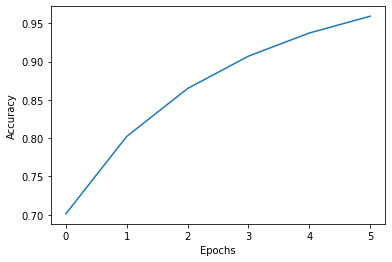

In [93]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Validation Accuracy')

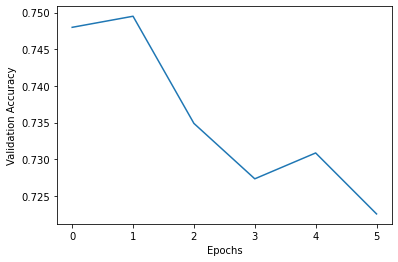

In [94]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [95]:

print(model.evaluate(test_padded,y_test))


27/27 [==============================] - 2s 57ms/step - loss: 0.4586 - accuracy: 0.7814
[0.4585571587085724, 0.7813953757286072]


In [96]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_padded, batch_size=128, verbose=1)
y_pred = (y_pred>0.5)
print(classification_report(y_test, y_pred))

7/7 [==============================] - 2s 153ms/step
              precision    recall  f1-score   support

           0       0.59      0.72      0.65       240
           1       0.88      0.80      0.84       620

    accuracy                           0.78       860
   macro avg       0.74      0.76      0.75       860
weighted avg       0.80      0.78      0.79       860



# Saving model


In [ ]:
model.save("models/bigruglovefastext.h5")

In [97]:
m = tf.keras.models.load_model("models/bigruglovefastext.h5")
m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 280, 300)          3000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 280, 128)          186880    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 280, 60)           38160     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               6100      
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2020      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)               